In [1]:
import astropy.units as u
import numpy as np
from astroquery.gaia import Gaia
from joblib import Memory
import matplotlib.pyplot as plt
from matplotlib import colors

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
def get_gaia_query_results(ra=66.75, dec=15.86, radius=2, conds="", limit=50000):
    add = ""
    if conds != "":
        add = f"AND {conds}"
    query = f"""
    SELECT TOP {limit} *
    FROM gaiaedr3.gaia_source
    WHERE 
        CONTAINS(
            POINT('ICRS',gaiaedr3.gaia_source.ra,gaiaedr3.gaia_source.dec),
            CIRCLE('ICRS',{ra},{dec},{radius})
        )=1
    """ + add
    job = Gaia.launch_job_async(query)
    return job.get_results()

In [3]:
location = "./cachedir"
memory = Memory(location, verbose=0)
get_gaia_query_results_cached = memory.cache(get_gaia_query_results)

In [33]:
stringent_conds = '''
    parallax_over_error > 10
    AND ABS(parallax - 21.052) < 5
    AND ABS(pmra-4.614) < 300
    AND ABS(pmdec+7.705) < 400
    AND phot_g_mean_flux_over_error>25
    AND phot_rp_mean_flux_over_error>10
    AND phot_bp_mean_flux_over_error>10
    AND pmra_error < 0.1
    AND pmdec_error < 0.1
    AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    AND astrometric_excess_noise < 1
'''
print("Starting stringent query...")
hyades_stringent = get_gaia_query_results_cached(radius = 5, conds = stringent_conds)

Starting stringent query...


In [34]:
less_conds = '''
    parallax_over_error > 10
    AND phot_g_mean_flux_over_error>50
    AND phot_rp_mean_flux_over_error>20
    AND phot_bp_mean_flux_over_error>20
    AND pmra_error < 0.1
    AND pmdec_error < 0.1
    AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2)
    AND astrometric_excess_noise < 1
'''
print("Starting condless query...")
hyades_condless = get_gaia_query_results_cached(radius = 5, conds=less_conds)

Starting condless query...


### Stringent Conditions

In [35]:
hyades_stringent

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,deg,deg,deg,deg
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float64,float64,float64,float64
1636042515805110273,Gaia EDR3 45142206521351552,45142206521351552,36940397,2016.0,61.92552108068629,0.027922241,15.162685906660181,0.01612104,22.850537135218378,0.028883275,791.1339,129.84071,127.74418003865537,0.04115653,-23.238637670992127,0.024343599,-0.11751028,-0.14225836,-0.13101809,0.078020446,-0.17627358,-0.036509227,0.29818922,0.23841596,-0.096694626,-0.30046558,188,188,184,4,-3.4162867,718.20984,0.15080813,27.235142,31,True,1.6350477,--,--,--,--,--,--,--,21,13,0.05856452,29,8,11,0.08220789,85.21746,2,0,0.8232454,--,--,--,--,--,--,--,--,False,218,76028334.11389707,27638.504,2750.8123,5.984928,26,46659496.63540592,40804.332,1143.4937,6.166192,25,43189434.45228092,46177.7,935.2877,5.6594515,0,0,0,0,0,1.1817822,0.50674057,0.18126392,0.32547665,37.93208,0.46552494,9,6750.0,4.5,0.0,177.37820091592712,-26.33015320399188,62.840611894997984,-5.66878349571724
1636042515805110273,Gaia EDR3 45159901786885632,45159901786885632,945169460,2016.0,61.755680961496566,0.015764592,15.334941426173367,0.010946775,22.22862392233613,0.017393649,1277.9736,126.18647,124.62563850797356,0.019903427,-19.785723427617143,0.0144358

In [37]:
bp_rp_hyades = hyades_stringent['bp_rp'].data
phot_g_mean_mag_hyades = hyades_stringent['phot_g_mean_mag'].data
parallax_hyades = hyades_stringent['parallax'].data
pmra_hyades = hyades_stringent['pmra'].data
pmdec_hyades = hyades_stringent['pmdec'].data
mg_hyades = phot_g_mean_mag_hyades+5*np.log10(parallax_hyades)-10

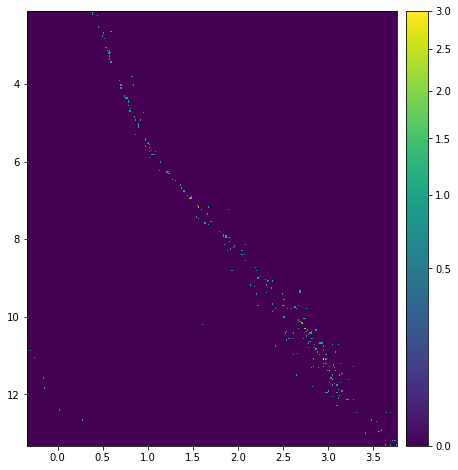

In [38]:
fig, ax = plt.subplots(figsize=(8,8))
h = ax.hist2d(bp_rp_hyades,mg_hyades,bins=300, norm=colors.PowerNorm(0.5), zorder=0.5)
ax.scatter(bp_rp_hyades, mg_hyades, alpha=0.05, s=1, color='k', zorder=0)
ax.invert_yaxis()
cb = plt.colorbar(h[3], ax=ax, pad=0.02)
plt.show()

In [40]:
print(f"RA mean: {np.mean(pmra_hyades)}, DEC mean:{np.mean(pmdec_hyades)}")
print(f"RA max: {np.max(pmra_hyades)}, DEC max: {np.max(pmdec_hyades)}")
print(f"RA min: {np.min(pmra_hyades)}, DEC min: {np.min(pmdec_hyades)}")

RA mean: 86.74581812332562, DEC mean:-38.3022036078993
RA max: 268.45112859881044, DEC max: 157.6947104412314
RA min: -229.02440169940525, DEC min: -327.9489428466409


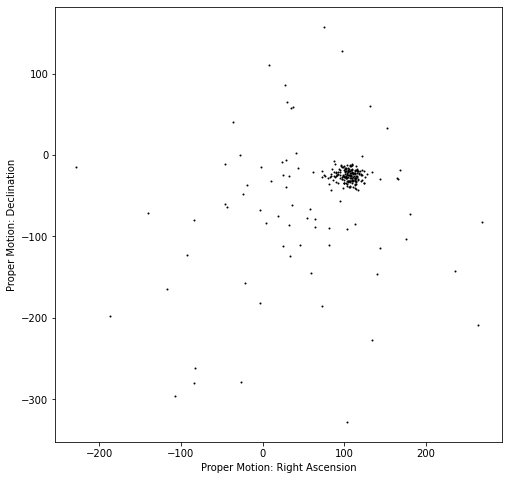

In [41]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(pmra_hyades, pmdec_hyades, s=1, color='k')
plt.xlabel("Proper Motion: Right Ascension")
plt.ylabel("Proper Motion: Declination")
plt.show()

### Conditionless (Limit 50,000)


In [42]:
hyades_condless

solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat
,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,deg,deg,deg,deg
int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float64,float64,float64,float64
1636042515805110273,Gaia EDR3 45903549604109184,45903549604109184,225872416,2016.0,62.28200531896495,0.037494704,16.618683701292667,0.027554745,0.806382297436968,0.04281058,18.83605,5.5238104,-2.6015379766632614,0.0557469,-4.872830887439466,0.042821407,0.19689064,0.1342041,0.021299718,0.009741926,-0.19762631,-0.016378166,0.26645094,0.156852,-0.022210894,0.21999034,278,0,275,3,1.4097203,314.46194,0.09023748,0.8564521,31,True,1.4213169,--,--,--,--,--,--,--,32,16,0.079487905,34,8,0,0.014144059,98.29156,1,0,1.060015,0.16060866,0.40707493,0.167498,0.42292354,-56.082623,-16.340183,-37.5405,34.949043,False,287,9007.327029998338,4.1523833,2169.1946,15.800877,33,3508.9774859102404,12.416609,282.60352,16.475592,33,8141.461930282397,11.239167,724.383,14.97114,0,2,0,0,0,1.2934402,1.5044518,0.67471504,0.8297367,--,--,0,--,--,--,176.42125209104879,-25.10776663475943,63.451765344990434,-4.302472362301102
1636042515805110273,Gaia EDR3 45903583963848320,45903583963848320,1616775635,2016.0,62.25789148177414,0.03346794,16.61942275783952,0.025504073,0.48253896425735626,0.038558803,12.514365,3.919604,2.594943759124962,0.047197632,

In [43]:
hyades_condless_pd = hyades_condless.to_pandas()
hyades_condless_pd = hyades_condless_pd[hyades_condless_pd['parallax'].notna()]
hyades_condless_pd = hyades_condless_pd[hyades_condless_pd['parallax'] > 0.5]
hyades_condless_pd = hyades_condless_pd[hyades_condless_pd['bp_rp'].notna()]

In [44]:
bp_rp_hyades_condless = hyades_condless_pd['bp_rp']
phot_g_mean_mag_hyades_condless = hyades_condless_pd['phot_g_mean_mag']
parallax_hyades_condless = hyades_condless_pd['parallax']
pmra_hyades_condless = hyades_condless_pd['pmra']
pmdec_hyades_condless = hyades_condless_pd['pmdec']
mg_hyades_condless = phot_g_mean_mag_hyades_condless+5*np.log10(parallax_hyades_condless)-10

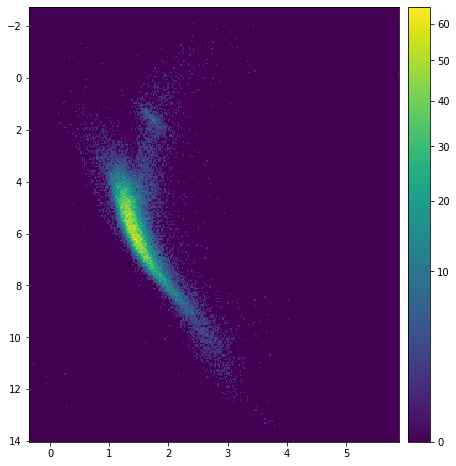

In [45]:
fig, ax = plt.subplots(figsize=(8,8))
h = ax.hist2d(bp_rp_hyades_condless,mg_hyades_condless,bins=300, norm=colors.PowerNorm(0.5), zorder=0.5)
ax.scatter(bp_rp_hyades_condless, mg_hyades_condless, alpha=0.05, s=1, color='k', zorder=0)
ax.invert_yaxis()
cb = plt.colorbar(h[3], ax=ax, pad=0.02)
plt.show()

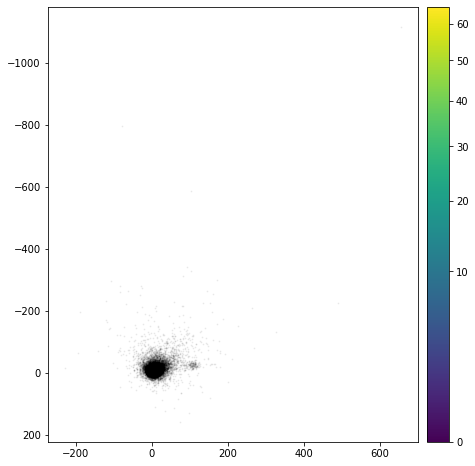

In [46]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(pmra_hyades_condless, pmdec_hyades_condless, alpha=0.05, s=1, color='k', zorder=0)
ax.invert_yaxis()
cb = plt.colorbar(h[3], ax=ax, pad=0.02)
plt.show()

## Isochrones, MIST Models

In [47]:
import sys
sys.path.append(".")
from glob import glob
from read_mist_models import ISOCMD

In [48]:
glob("*")

['cachedir',
 'lab0.ipynb',
 'lab0.pdf',
 'Lab_0_Astr128_2021.pdf',
 'MIST_iso_60173edbd8484.iso.cmd',
 'MIST_iso_601751b1dcb3c.iso.cmd',
 'MIST_iso_6017590e63448.iso.cmd',
 'read_mist_models.py',
 '__pycache__']

In [63]:
mist_fnames = glob("MIST*.iso.cmd")
isocmd_02 = ISOCMD(mist_fnames[2])
isocmd_13 = ISOCMD(mist_fnames[0])

Reading in: MIST_iso_6017590e63448.iso.cmd
Reading in: MIST_iso_60173edbd8484.iso.cmd


In [64]:
print('version: ', isocmd.version)
print('photometric system: ', isocmd.photo_sys)
print('abundances: ', isocmd.abun)
print('rotation: ', isocmd.rot)
print('ages: ', [round(x,2) for x in isocmd.ages])
print('number of ages: ', isocmd.num_ages)
print('available columns: ', isocmd.hdr_list)
print('Av extinction: ', isocmd.Av_extinction)

version:  {'MIST': '1.2', 'MESA': '7503'}
photometric system:  UBV(RI)c, 2MASS, Kepler, Hipparcos, Gaia (Vega)
abundances:  {'Yinit': 0.2773, 'Zinit': 0.0188444, '[Fe/H]': 0.13, '[a/Fe]': 0.0}
rotation:  0.4
ages:  [5.0, 5.05, 5.1, 5.15, 5.2, 5.25, 5.3, 5.35, 5.4, 5.45, 5.5, 5.55, 5.6, 5.65, 5.7, 5.75, 5.8, 5.85, 5.9, 5.95, 6.0, 6.05, 6.1, 6.15, 6.2, 6.25, 6.3, 6.35, 6.4, 6.45, 6.5, 6.55, 6.6, 6.65, 6.7, 6.75, 6.8, 6.85, 6.9, 6.95, 7.0, 7.05, 7.1, 7.15, 7.2, 7.25, 7.3, 7.35, 7.4, 7.45, 7.5, 7.55, 7.6, 7.65, 7.7, 7.75, 7.8, 7.85, 7.9, 7.95, 8.0, 8.05, 8.1, 8.15, 8.2, 8.25, 8.3, 8.35, 8.4, 8.45, 8.5, 8.55, 8.6, 8.65, 8.7, 8.75, 8.8, 8.85, 8.9, 8.95, 9.0, 9.05, 9.1, 9.15, 9.2, 9.25, 9.3, 9.35, 9.4, 9.45, 9.5, 9.55, 9.6, 9.65, 9.7, 9.75, 9.8, 9.85, 9.9, 9.95, 10.0, 10.05, 10.1, 10.15, 10.2, 10.25, 10.3]
number of ages:  107
available columns:  ['EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U', 'Bessell_B', 'Bes

In [65]:
def plot_temp_lum(isocmd = isocmd, age_index=5.0):
    age_ind = isocmd.age_index(age_index)
#     logTeff = isocmd.isocmds[age_ind]['log_Teff']
    logTeff = isocmd.isocmds[age_ind]['Gaia_BP_DR2Rev'] - isocmd.isocmds[age_ind]['Gaia_RP_DR2Rev']
    logL = isocmd.isocmds[age_ind]['Gaia_G_DR2Rev']
    fe_h = isocmd.abun['[Fe/H]']
#     print(isocmd.isocmds[age_ind]['[Fe/H]'])
    plt.plot(logTeff, logL, label=f"Age Index: {age_index}, Z: {fe_h}")
    plt.xlabel("logTeff")
    plt.ylabel("logL")
    plt.legend()

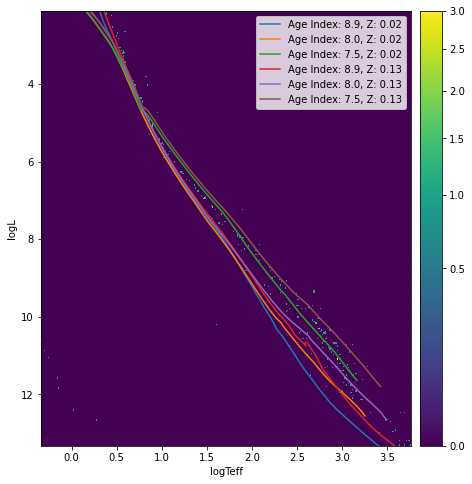

In [66]:
fig, ax = plt.subplots(figsize=(8,8))
h = ax.hist2d(bp_rp_hyades,mg_hyades,bins=300, norm=colors.PowerNorm(0.5), zorder=0.5)
ax.scatter(bp_rp_hyades, mg_hyades, alpha=0.05, s=1, color='k', zorder=0)
plot_temp_lum(isocmd_02, 8.9)
plot_temp_lum(isocmd_02, 8.0)
plot_temp_lum(isocmd_02, 7.5)
plot_temp_lum(isocmd_13, 8.9)
plot_temp_lum(isocmd_13, 8.0)
plot_temp_lum(isocmd_13, 7.5)
ax.invert_yaxis()
cb = plt.colorbar(h[3], ax=ax, pad=0.02)
plt.show()